In [ ]:
import math
import math
import math

def get_lr(num_iters, warmup_iter, start_lr, end_iter, min_lr, decay_style, num_repeats=1, constant_lr=0, cooldown_iters_percent=0, cooldown_iter_before_scale=0, timescale=0, constant_iters_percent=0, max_lr=0):
    """Learning rate decay functions from:
    https://openreview.net/pdf?id=BJYwwY9ll pg. 4"""

    constant_iter = constant_iters_percent * end_iter
    cooldown_iter = cooldown_iters_percent * end_iter

    if decay_style != 'cosine-inf':
      num_repeats = 1
    repeat_iter_interval = int(end_iter / num_repeats)

    if decay_style == "cosine-inf":
      warmup = warmup_iter / end_iter
      warmup_iter = warmup * int(end_iter / num_repeats)

    # Warmup.

    if warmup_iter > 0 and num_iters <= warmup_iter:
        return float(start_lr) * num_iters / warmup_iter
    elif decay_style == 'cosine-inf' \
    and warmup_iter > 0 \
    and num_iters % repeat_iter_interval <= warmup_iter:
        return float(min_lr) + float(start_lr - min_lr) * (num_iters % repeat_iter_interval) / warmup_iter

    num_iters = (num_iters % repeat_iter_interval) - warmup_iter
    if decay_style == "linear":
        lr = start_lr * (end_iter - num_iters) / end_iter
    elif decay_style == "cosine":
        end_iter_ = end_iter - warmup_iter
        lr = min_lr + (
            (start_lr - min_lr)
            / 2.0
            * (math.cos(math.pi * num_iters / end_iter_) + 1)
        )
    elif decay_style == "cosine-inf":
        end_iter_ = repeat_iter_interval - warmup_iter
        lr = min_lr + (
            (start_lr-min_lr)
            / 2.0
            * (math.cos(math.pi * num_iters / end_iter_) + 1)
        )
    elif decay_style == "exponential":
        # exp(-0.693) = 1/2
        lr = start_lr * math.exp(-0.693 * num_iters / end_iter)
    elif "infinite" in decay_style:
      if num_iters <= constant_iter:
          if num_iters <= cooldown_iter:
            if decay_style == "constant_infinite":
              # Do linear decay from start_lr to constant_lr
              lr = start_lr - ((start_lr - constant_lr) * num_iters) / cooldown_iter
              return lr
            elif decay_style == "inverse_sqrt_infinite":
              def inv_sqrt(x):
                return start_lr/math.sqrt((x + timescale)/timescale)

              def y_shifted(x, func, A, B_new, x_start, x_end):
                return ((B_new - A) / (func(x_end) - func(x_start))) * func(x) + A - ((B_new - A) / (func(x_end) - func(x_start))) * func(x_start)

              def x_shifted(x, func, x_start, x_end, x_end_new):
                k = (x_end_new - x_start) / (x_end - x_start)
                return func(((x - x_start) / k) + x_start)

              y_shifted_func = lambda x: y_shifted(x, inv_sqrt, start_lr, constant_lr, 0, cooldown_iter_before_scale)
              x_shifted_func = lambda x: x_shifted(x, y_shifted_func, 0, cooldown_iter_before_scale, cooldown_iter)
              lr = x_shifted_func(num_iters)
              return lr
            else:
              raise NotImplementedError
          else:
            # Stay at constant LR
            lr = constant_lr
            return lr
      else:
        # Go from constant iters to min LR in remaining iters
        end_iter_ = end_iter - warmup_iter - constant_iter
        num_iters = num_iters - constant_iter
        exp_factor = -math.log(min_lr/constant_lr) / end_iter_
        lr = constant_lr * math.exp(-1* exp_factor * num_iters)
    else:
        lr = start_lr
    return max(lr, min_lr)

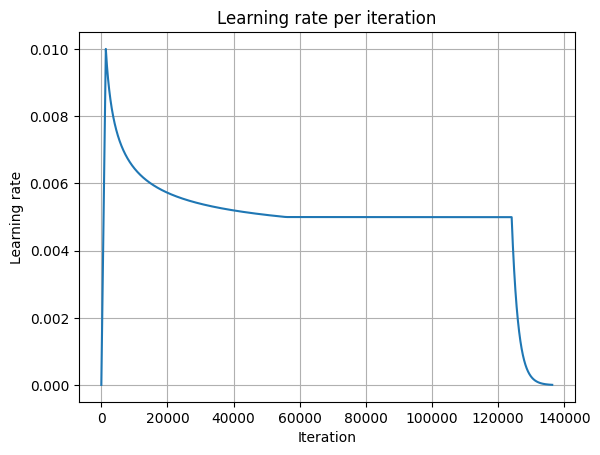

In [ ]:
import matplotlib.pyplot as plt

start_lr = 0.01
min_lr = 0.00001
constant_lr = 0.005
end_iter = 136363
warmup_iter_percent = 0.01
warmup_iter = int(warmup_iter_percent * end_iter)
constant_iters_percent = 0.9
cooldown_iters_percent = 0.4
cooldown_iter_before_scale = 300
timescale = 10
num_repeats=1
decay_style = "inverse_sqrt_infinite"

iterations = list(range(1, end_iter))
lrs = [get_lr(num_iters, warmup_iter, start_lr, end_iter, min_lr, decay_style, num_repeats=num_repeats, constant_lr=constant_lr, cooldown_iters_percent=cooldown_iters_percent, cooldown_iter_before_scale=cooldown_iter_before_scale, timescale=timescale, constant_iters_percent=constant_iters_percent, max_lr=0) for num_iters in iterations]

# Plotting
plt.plot(iterations, lrs)
plt.title('Learning rate per iteration')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.grid(True)
plt.show()